PROJECT_ROOT = C:\Users\yixiao Zhou\Desktop\image-based-phenotyping-pipeline

Resolved paths:
toy_images_dir   = C:\Users\yixiao Zhou\Desktop\image-based-phenotyping-pipeline\data\toy_data\images
toy_metadata_dir = C:\Users\yixiao Zhou\Desktop\image-based-phenotyping-pipeline\data\toy_data\metadata
figures_dir      = C:\Users\yixiao Zhou\Desktop\image-based-phenotyping-pipeline\figures
Channels: {0: 'DAPI', 1: 'LysosomeA', 2: 'LysosomeB', 3: 'Ch3'}
Analysis: LysosomeA vs LysosomeB

N tiles found (treated/untreated): 12
Saved manifest: C:\Users\yixiao Zhou\Desktop\image-based-phenotyping-pipeline\data\toy_data\metadata\02_manifest__LysosomeA_vs_LysosomeB.csv
Saved parameter snapshot: C:\Users\yixiao Zhou\Desktop\image-based-phenotyping-pipeline\figures\02_params__LysosomeA_vs_LysosomeB.txt
Saved QC: C:\Users\yixiao Zhou\Desktop\image-based-phenotyping-pipeline\figures\02_qc_cells_plus_nuclei__tile_019_y576_x768_C4__LysosomeA_vs_LysosomeB.png


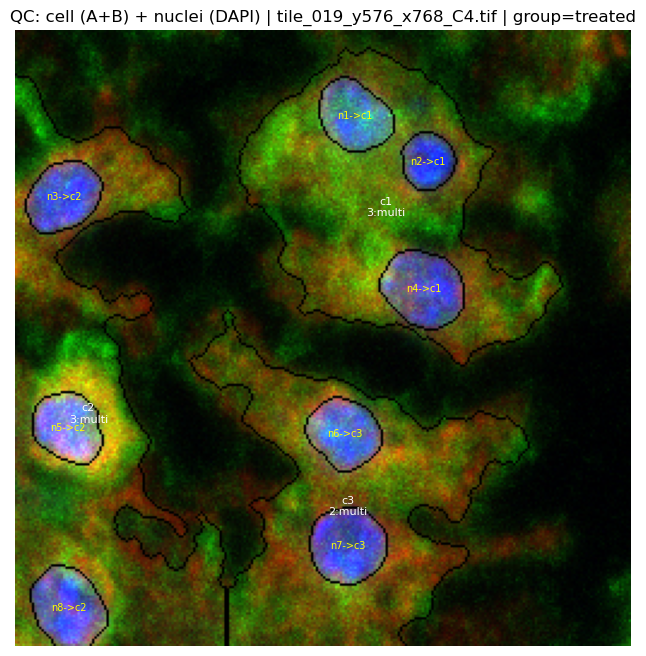


Cells: 35 Columns: 16


group                       tile  cell_id  nuclei_in_cell cell_class  \
0  treated  tile_019_y576_x768_C4.tif        1               3      multi   
1  treated  tile_019_y576_x768_C4.tif        2               3      multi   
2  treated  tile_019_y576_x768_C4.tif        3               2      multi   
3  treated    tile_020_y768_x0_C4.tif        1               1       mono   
4  treated    tile_020_y768_x0_C4.tif        2               1       mono   

   cell_center_row  cell_center_col       R_px  r_perinuclear_px  \
0        73.101012       153.507983  55.230097         13.807524   
1       158.965602        30.007049  61.219119         15.304780   
2       197.421936       137.858482  54.032752         13.508188   
3        84.134119        25.736027  53.255432         13.313858   
4        72.867589       139.039970  40.992169         10.248042   

   mean_norm_radius_LysosomeA  mean_norm_radius_LysosomeB  \
0                    0.702350                    0.684888   
1                    0.961937                    0.951876   
2                    0.713223                    0.725517   
3                    0.878448                    0.911895   
4                    0.765426                    0.725437   

   perinuclear_fraction_LysosomeA  perinuclear_fraction_LysosomeB  \
0                        0.068968                        0.078394   
1                        0.117841                        0.109457   
2                        0.066862                        0.058624   
3                        0.065356                        0.081431   
4                        0.062770                        0.073502   

   cv_intensity_LysosomeA  cv_intensity_LysosomeB  \
0                0.412221                0.359811   
1                0.556983                0.430804   
2                0.359896                0.318574   
3                0.521998                0.339994   
4                0.278127                0.380485   

   radial_coupling_LysosomeA_vs_LysosomeB  
0                                0.213571  
1                                0.917228  
2                                0.329628  
3                               -0.042844  
4                                0.151644


Saved CSV: C:\Users\yixiao Zhou\Desktop\image-based-phenotyping-pipeline\data\toy_data\metadata\toy_cell_spatial_features__LysosomeA_vs_LysosomeB.csv
Exists   : True

Cell class by group:
 cell_class  mono  multi
group                  
treated        8     11
untreated      9      7


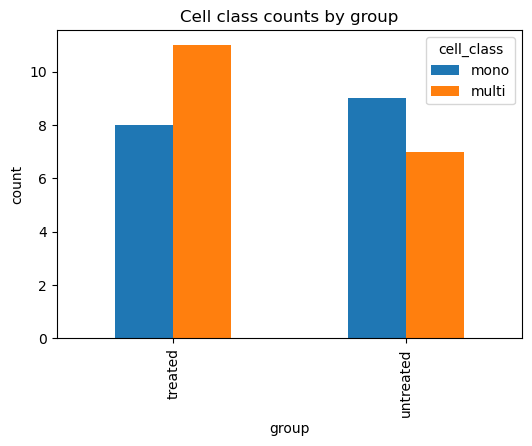

Saved: C:\Users\yixiao Zhou\Desktop\image-based-phenotyping-pipeline\figures\02_bar_cell_class_by_group__LysosomeA_vs_LysosomeB.png


<Figure size 600x400 with 0 Axes>

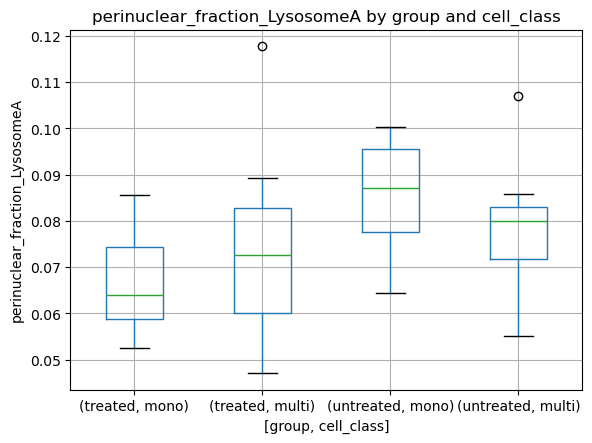

Saved: C:\Users\yixiao Zhou\Desktop\image-based-phenotyping-pipeline\figures\02_boxplot_perinuclear_fraction_LysosomeA__group__LysosomeA_vs_LysosomeB.png


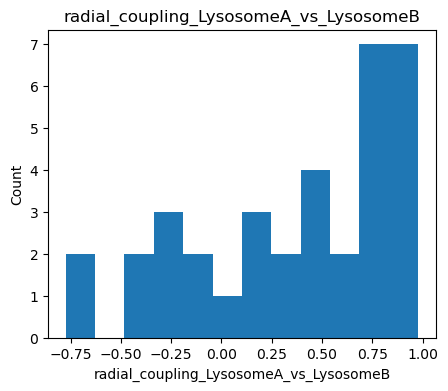

Saved: C:\Users\yixiao Zhou\Desktop\image-based-phenotyping-pipeline\figures\02_hist_radial_coupling_LysosomeA_vs_LysosomeB__LysosomeA_vs_LysosomeB.png


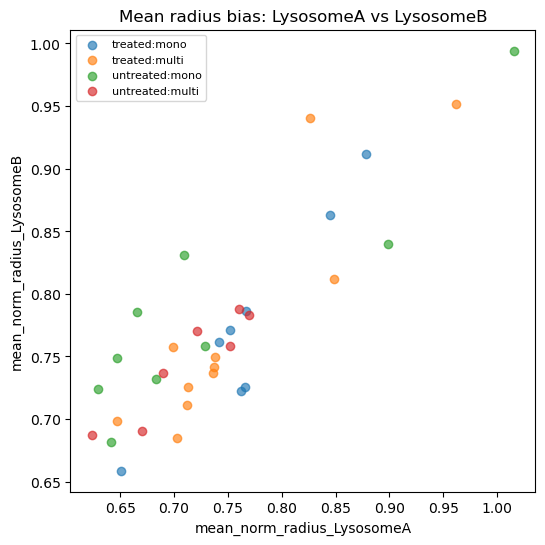

Saved: C:\Users\yixiao Zhou\Desktop\image-based-phenotyping-pipeline\figures\02_scatter_mean_radius__group__LysosomeA_vs_LysosomeB.png


In [1]:
# =========================================================
# Notebook2 (final, single-cell runnable)
# Cell-first spatial phenotyping with treated/untreated tags
# Pipeline: (A+B) cell segmentation -> DAPI nucleus segmentation -> nucleus-to-cell assignment -> features
# Outputs:
#   - data/toy_data/metadata/02_manifest__LysosomeA_vs_LysosomeB.csv
#   - data/toy_data/metadata/toy_cell_spatial_features__LysosomeA_vs_LysosomeB.csv
#   - figures/02_*.png and 02_params__*.txt
# =========================================================

import sys
from pathlib import Path
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# -------------------------
# 0) Robust project root discovery
# -------------------------
PROJECT_ROOT = None
for p in [Path.cwd(), *Path.cwd().parents]:
    if (p / "src").is_dir():
        PROJECT_ROOT = p
        break
if PROJECT_ROOT is None:
    raise RuntimeError("Cannot locate project root containing 'src/'.")
if str(PROJECT_ROOT) not in sys.path:
    sys.path.insert(0, str(PROJECT_ROOT))
print("PROJECT_ROOT =", PROJECT_ROOT.resolve())

# -------------------------
# 1) Imports from src/
# -------------------------
from src.config import PipelineConfig
from src.io_utils import read_multichannel_tif, ensure_dir
from src.preprocess import apply_gamma, smooth
from src.segmentation import segment_nuclei
from src.viz import make_rgb

cfg = PipelineConfig()

# =========================================================
# 2) Manual tuning area (edit only this section)
# =========================================================
CHANNELS = {0: "DAPI", 1: "LysosomeA", 2: "LysosomeB", 3: "Ch3"}

ANALYSIS_CHANNEL_A = 1
ANALYSIS_CHANNEL_B = 2
A_NAME = CHANNELS.get(ANALYSIS_CHANNEL_A, f"ch{ANALYSIS_CHANNEL_A}")
B_NAME = CHANNELS.get(ANALYSIS_CHANNEL_B, f"ch{ANALYSIS_CHANNEL_B}")

# Expect:
#   data/toy_data/images/treated/*.tif*
#   data/toy_data/images/untreated/*.tif*
cfg.paths.toy_images_dir = PROJECT_ROOT / "data" / "toy_data" / "images"
cfg.paths.toy_metadata_dir = PROJECT_ROOT / "data" / "toy_data" / "metadata"
cfg.paths.figures_dir = PROJECT_ROOT / "figures"

cfg.preview.rgb_channels = (ANALYSIS_CHANNEL_A, ANALYSIS_CHANNEL_B, 0)

# Nucleus segmentation (DAPI)
cfg.nucleus.dapi_channel = 0
cfg.nucleus.threshold_method = "otsu"     # "otsu" or "percentile"
cfg.nucleus.percentile = 99.3
cfg.nucleus.min_area = 300
cfg.nucleus.max_area = None
cfg.nucleus.closing_radius = 3
cfg.nucleus.opening_radius = 2
cfg.nucleus.split_touching = True
cfg.nucleus.min_peak_distance = 8
cfg.nucleus.distance_transform_sigma = 1.0

# Preprocess for nucleus segmentation
cfg.preprocess.apply_gamma = True
cfg.preprocess.gamma = 0.85
cfg.preprocess.gaussian_sigma = 1.0

# Cell segmentation from A+B
CELL_COMBINE_MODE = "max"                 # "max" recommended; "sum" optional
CELL_SMOOTH_SIGMA = 1.0
CELL_THR_METHOD = "otsu"                  # "otsu" or "percentile"
CELL_THR_PERCENTILE = 99.0
CELL_OPENING = 1
CELL_CLOSING = 4
CELL_MIN_AREA = 2500
CELL_SPLIT_TOUCHING = True

# watershed seed control (reduce false splits)
CELL_WATERSHED_SMOOTH_SIGMA = 3.0         # stronger smoothing on distance map reduces false peaks
CELL_HMAXIMA_H = 4                      # bigger => fewer seeds => fewer splits

# merge obvious false cuts (optional)
CELL_MERGE_FALSE_CUTS = True
CELL_MERGE_BOUNDARY_MEAN_GT = 0.45        # bigger => merge more aggressively
CELL_MERGE_MIN_REGION_AREA = 500

# Nucleus-to-cell assignment
NUC_CELL_MIN_OVERLAP_PX = 20

# Features
N_RADIAL_BINS = 12
PERINUCLEAR_R_FRACTION = 0.25
PERINUCLEAR_R_PX = None

# Outputs
SAVE_FIGURES = True
QC_TILE_INDEX = 0

print("\nResolved paths:")
print("toy_images_dir   =", cfg.paths.toy_images_dir.resolve())
print("toy_metadata_dir =", cfg.paths.toy_metadata_dir.resolve())
print("figures_dir      =", cfg.paths.figures_dir.resolve())
print("Channels:", CHANNELS)
print(f"Analysis: {A_NAME} vs {B_NAME}")

# =========================================================
# 3) Discover tiles from treated/untreated + manifest + param snapshot
# =========================================================
def list_tiles_with_group(root_dir: Path, exts=(".tif", ".tiff")):
    root_dir = Path(root_dir)
    groups = ["treated", "untreated"]
    out = []
    for g in groups:
        gdir = root_dir / g
        if not gdir.exists():
            print(f"[WARN] Missing folder: {gdir}")
            continue
        for p in sorted(gdir.iterdir()):
            if p.is_file() and p.suffix.lower() in exts:
                out.append({"tile_path": str(p.resolve()), "tile_name": p.name, "group": g})
    return out

tiles_info = list_tiles_with_group(cfg.paths.toy_images_dir)
print("\nN tiles found (treated/untreated):", len(tiles_info))
if len(tiles_info) == 0:
    raise FileNotFoundError(
        "No TIFF tiles found. Expected:\n"
        f"  {cfg.paths.toy_images_dir / 'treated'}\n"
        f"  {cfg.paths.toy_images_dir / 'untreated'}"
    )

ensure_dir(cfg.paths.toy_metadata_dir)
ensure_dir(cfg.paths.figures_dir)

manifest = pd.DataFrame(tiles_info)
manifest_path = cfg.paths.toy_metadata_dir / f"02_manifest__{A_NAME}_vs_{B_NAME}.csv"
manifest.to_csv(manifest_path, index=False)
print("Saved manifest:", manifest_path.resolve())

tiles = manifest["tile_path"].tolist()

param_lines = [
    f"PROJECT_ROOT={PROJECT_ROOT.resolve()}",
    f"toy_images_dir={cfg.paths.toy_images_dir.resolve()}",
    f"toy_metadata_dir={cfg.paths.toy_metadata_dir.resolve()}",
    f"figures_dir={cfg.paths.figures_dir.resolve()}",
    f"DATA_LAYOUT=two_subfolders: treated/untreated",
    f"N_TILES={len(tiles_info)}",
    f"CHANNELS={CHANNELS}",
    f"ANALYSIS_CHANNEL_A={ANALYSIS_CHANNEL_A} ({A_NAME})",
    f"ANALYSIS_CHANNEL_B={ANALYSIS_CHANNEL_B} ({B_NAME})",
    f"rgb_channels={cfg.preview.rgb_channels}",
    f"nucleus: method={cfg.nucleus.threshold_method}, percentile={cfg.nucleus.percentile}, min_area={cfg.nucleus.min_area}, closing={cfg.nucleus.closing_radius}, opening={cfg.nucleus.opening_radius}",
    f"nucleus: split_touching={cfg.nucleus.split_touching}, min_peak_distance={cfg.nucleus.min_peak_distance}, dt_sigma={cfg.nucleus.distance_transform_sigma}",
    f"preprocess: gamma={cfg.preprocess.gamma}, gaussian_sigma={cfg.preprocess.gaussian_sigma}",
    f"cell: combine={CELL_COMBINE_MODE}, smooth_sigma={CELL_SMOOTH_SIGMA}, thr={CELL_THR_METHOD}, perc={CELL_THR_PERCENTILE}",
    f"cell: opening={CELL_OPENING}, closing={CELL_CLOSING}, min_area={CELL_MIN_AREA}, split_touching={CELL_SPLIT_TOUCHING}",
    f"cell: dt_smooth_sigma={CELL_WATERSHED_SMOOTH_SIGMA}, hmaxima_H={CELL_HMAXIMA_H}",
    f"cell: merge_false_cuts={CELL_MERGE_FALSE_CUTS}, merge_boundary_mean_gt={CELL_MERGE_BOUNDARY_MEAN_GT}, merge_min_region_area={CELL_MERGE_MIN_REGION_AREA}",
    f"assign: NUC_CELL_MIN_OVERLAP_PX={NUC_CELL_MIN_OVERLAP_PX}",
    f"features: N_RADIAL_BINS={N_RADIAL_BINS}, PERINUCLEAR_R_FRACTION={PERINUCLEAR_R_FRACTION}, PERINUCLEAR_R_PX={PERINUCLEAR_R_PX}",
]
param_txt = cfg.paths.figures_dir / f"02_params__{A_NAME}_vs_{B_NAME}.txt"
param_txt.write_text("\n".join(param_lines), encoding="utf-8")
print("Saved parameter snapshot:", param_txt.resolve())

# =========================================================
# 4) Helper functions
# =========================================================
from skimage import filters, morphology, measure, segmentation
from scipy import ndimage as ndi
from skimage.segmentation import find_boundaries, relabel_sequential

def _norm01(x, eps=1e-8):
    x = x.astype(np.float32)
    lo, hi = np.percentile(x, 1), np.percentile(x, 99.5)
    x = (x - lo) / (hi - lo + eps)
    return np.clip(x, 0, 1)

def _contact_boundary(lab, a1, a2):
    m1 = (lab == a1)
    m2 = (lab == a2)
    d1 = morphology.dilation(m1, morphology.disk(1))
    d2 = morphology.dilation(m2, morphology.disk(1))
    return d1 & d2

def _merge_false_cuts_by_joint_boundary(labels, joint,
                                       boundary_dilate=1,
                                       merge_if_boundary_mean_gt=0.35,
                                       min_region_area=500):
    lab = labels.copy().astype(np.int32)
    if lab.max() <= 1:
        return lab

    def _areas(lab_):
        return {p.label: p.area for p in measure.regionprops(lab_)}

    area = _areas(lab)

    b = segmentation.find_boundaries(lab, mode="outer")
    if boundary_dilate and boundary_dilate > 0:
        b = morphology.dilation(b, morphology.disk(boundary_dilate))

    rr, cc = np.where(b)
    pairs = set()
    H, W = lab.shape
    for r, c in zip(rr, cc):
        v = lab[r, c]
        for dr, dc in ((-1,0),(1,0),(0,-1),(0,1)):
            r2, c2 = r+dr, c+dc
            if r2 < 0 or r2 >= H or c2 < 0 or c2 >= W:
                continue
            u = lab[r2, c2]
            if v > 0 and u > 0 and v != u:
                a1, a2 = (v, u) if v < u else (u, v)
                pairs.add((a1, a2))

    changed = True
    while changed:
        changed = False
        for a1, a2 in list(pairs):
            if a1 not in area or a2 not in area:
                continue
            if area[a1] < min_region_area or area[a2] < min_region_area:
                continue

            boundary = _contact_boundary(lab, a1, a2)
            if boundary.sum() < 20:
                continue

            bmean = float(np.mean(joint[boundary]))
            if bmean > merge_if_boundary_mean_gt:
                keep = a1 if area[a1] >= area[a2] else a2
                kill = a2 if keep == a1 else a1
                lab[lab == kill] = keep
                lab, _, _ = relabel_sequential(lab)
                area = _areas(lab)
                changed = True
                break

    lab, _, _ = relabel_sequential(lab)
    return lab.astype(np.int32)

def segment_cells_from_AB(A, B):
    a = _norm01(A)
    b = _norm01(B)
    if CELL_SMOOTH_SIGMA and CELL_SMOOTH_SIGMA > 0:
        a = ndi.gaussian_filter(a, CELL_SMOOTH_SIGMA)
        b = ndi.gaussian_filter(b, CELL_SMOOTH_SIGMA)

    if CELL_COMBINE_MODE == "sum":
        joint = a + b
        joint = joint / (joint.max() + 1e-8)
    else:
        joint = np.maximum(a, b)

    if CELL_THR_METHOD == "otsu":
        thr = filters.threshold_otsu(joint)
    else:
        thr = np.percentile(joint, CELL_THR_PERCENTILE)

    m = joint > thr
    if CELL_OPENING and CELL_OPENING > 0:
        m = morphology.opening(m, morphology.disk(CELL_OPENING))
    if CELL_CLOSING and CELL_CLOSING > 0:
        m = morphology.closing(m, morphology.disk(CELL_CLOSING))

    m = morphology.remove_small_objects(m, CELL_MIN_AREA)
    m = ndi.binary_fill_holes(m)
    m = morphology.remove_small_holes(m.astype(bool), area_threshold=800).astype(bool)

    if not CELL_SPLIT_TOUCHING:
        return m.astype(bool), measure.label(m).astype(np.int32)

    dist = ndi.distance_transform_edt(m).astype(np.float32)
    dist_s = ndi.gaussian_filter(dist, float(CELL_WATERSHED_SMOOTH_SIGMA))

    hmax = morphology.h_maxima(dist_s, float(CELL_HMAXIMA_H))
    markers = measure.label(hmax).astype(np.int32)

    if markers.max() == 0:
        labels = measure.label(m).astype(np.int32)
    else:
        labels = segmentation.watershed(-dist_s, markers=markers, mask=m).astype(np.int32)

    if CELL_MERGE_FALSE_CUTS:
        labels = _merge_false_cuts_by_joint_boundary(
            labels, joint,
            boundary_dilate=1,
            merge_if_boundary_mean_gt=float(CELL_MERGE_BOUNDARY_MEAN_GT),
            min_region_area=int(CELL_MERGE_MIN_REGION_AREA),
        )

    return m.astype(bool), labels.astype(np.int32)

def segment_nuclei_labels(cyx):
    dapi = cyx[cfg.nucleus.dapi_channel].astype(np.float32)
    x = dapi
    if cfg.preprocess.apply_gamma:
        x = apply_gamma(x, cfg.preprocess.gamma)
    x = smooth(x, cfg.preprocess.gaussian_sigma)

    nuc_labels = segment_nuclei(
        x,
        threshold_method=cfg.nucleus.threshold_method,
        percentile=cfg.nucleus.percentile,
        min_area=cfg.nucleus.min_area,
        max_area=cfg.nucleus.max_area,
        closing_radius=cfg.nucleus.closing_radius,
        opening_radius=cfg.nucleus.opening_radius,
        split_touching=cfg.nucleus.split_touching,
        distance_transform_sigma=cfg.nucleus.distance_transform_sigma,
        min_peak_distance=cfg.nucleus.min_peak_distance,
    ).astype(np.int32)

    return nuc_labels

def assign_nuclei_to_cells(nuc_labels, cell_labels, min_overlap_px=20):
    nucleus_to_cell = {}
    nuclei_per_cell = {}

    nuc_ids = np.unique(nuc_labels)
    nuc_ids = nuc_ids[nuc_ids > 0]

    for nid in nuc_ids:
        nm = (nuc_labels == nid)
        overlapped = cell_labels[nm]
        overlapped = overlapped[overlapped > 0]
        if overlapped.size < int(min_overlap_px):
            nucleus_to_cell[int(nid)] = 0
            continue
        vals, counts = np.unique(overlapped, return_counts=True)
        cid = int(vals[np.argmax(counts)])
        nucleus_to_cell[int(nid)] = cid
        nuclei_per_cell[cid] = nuclei_per_cell.get(cid, 0) + 1

    return nucleus_to_cell, nuclei_per_cell

def radial_distance_map(center_rc, shape_hw):
    rr, cc = np.indices(shape_hw)
    r0, c0 = float(center_rc[0]), float(center_rc[1])
    return np.sqrt((rr - r0) ** 2 + (cc - c0) ** 2).astype(np.float32)

def infer_R_from_mask(cell_mask, eps=1e-8):
    area = float(np.sum(cell_mask))
    if area < 50:
        return float("nan")
    return float(np.sqrt(area / (np.pi + eps)))

def weighted_mean_norm_radius(signal2d, center_rc, R, mask=None, eps=1e-8):
    sig = signal2d.astype(np.float32)
    d = radial_distance_map(center_rc, sig.shape)
    if mask is not None:
        sig = sig * mask.astype(np.float32)
    denom = float(sig.sum()) + eps
    return float((sig * (d / float(R))).sum() / denom)

def perinuclear_fraction(signal2d, center_rc, r_p, mask=None, eps=1e-8):
    sig = signal2d.astype(np.float32)
    d = radial_distance_map(center_rc, sig.shape)
    valid = np.ones(sig.shape, dtype=bool) if mask is None else mask.astype(bool)
    denom = float(sig[valid].sum()) + eps
    num = float(sig[valid & (d <= float(r_p))].sum())
    return float(num / denom)

def intensity_cv(signal2d, mask=None, eps=1e-8):
    sig = signal2d.astype(np.float32)
    if mask is not None:
        sig = sig[mask.astype(bool)]
    if sig.size < 10:
        return float("nan")
    mu = float(sig.mean())
    sd = float(sig.std())
    if mu <= eps:
        return float("nan")
    return float(sd / (mu + eps))

def radial_profile(signal2d, center_rc, n_bins=12, max_radius=None, mask=None):
    sig = signal2d.astype(np.float32)
    d = radial_distance_map(center_rc, sig.shape)
    valid = np.ones(sig.shape, dtype=bool) if mask is None else mask.astype(bool)

    if max_radius is None or (not np.isfinite(max_radius)):
        max_radius = float(d[valid].max())

    edges = np.linspace(0.0, float(max_radius), int(n_bins) + 1)
    prof = np.full(int(n_bins), np.nan, dtype=np.float32)

    for i in range(int(n_bins)):
        m = valid & (d >= edges[i]) & (d < edges[i + 1])
        if np.any(m):
            prof[i] = sig[m].mean()

    centers = 0.5 * (edges[:-1] + edges[1:])
    return centers.astype(np.float32), prof

def radial_coupling_cosine(profile_a, profile_b, eps=1e-8):
    a = np.asarray(profile_a, dtype=np.float32)
    b = np.asarray(profile_b, dtype=np.float32)
    m = np.isfinite(a) & np.isfinite(b)
    if m.sum() < 3:
        return float("nan")
    a = a[m] - float(a[m].mean())
    b = b[m] - float(b[m].mean())
    na = float(np.linalg.norm(a))
    nb = float(np.linalg.norm(b))
    if na <= eps or nb <= eps:
        return float("nan")
    return float(np.dot(a, b) / (na * nb + eps))

# =========================================================
# 5) QC tile: boundaries + labels (includes group tag)
# =========================================================
qc_row = manifest.iloc[int(QC_TILE_INDEX)]
qc_tile = Path(qc_row["tile_path"])
qc_group = str(qc_row["group"])

cyx_qc = read_multichannel_tif(qc_tile).astype(np.float32)
A_qc = cyx_qc[ANALYSIS_CHANNEL_A].astype(np.float32)
B_qc = cyx_qc[ANALYSIS_CHANNEL_B].astype(np.float32)

cell_mask_qc, cell_labels_qc = segment_cells_from_AB(A_qc, B_qc)
nuc_labels_qc = segment_nuclei_labels(cyx_qc)

nucleus_to_cell_qc, nuclei_per_cell_qc = assign_nuclei_to_cells(
    nuc_labels_qc, cell_labels_qc, min_overlap_px=NUC_CELL_MIN_OVERLAP_PX
)

rgb_qc = make_rgb(cyx_qc, cfg.preview.rgb_channels)
bnd_cells = find_boundaries(cell_labels_qc, mode="outer")
bnd_nucs = find_boundaries(nuc_labels_qc, mode="outer")

rgb_qc2 = rgb_qc.copy()
rgb_qc2[bnd_cells] = 1.0
rgb_qc2[bnd_nucs] = np.clip(rgb_qc2[bnd_nucs] + 0.5, 0, 1)

plt.figure(figsize=(8, 8))
plt.title(f"QC: cell (A+B) + nuclei (DAPI) | {qc_tile.name} | group={qc_group}")
plt.imshow(rgb_qc2)
plt.axis("off")

cell_ids = np.unique(cell_labels_qc)
cell_ids = cell_ids[cell_ids > 0]
for cid in cell_ids:
    cm = (cell_labels_qc == cid)
    rr, cc = np.where(cm)
    if rr.size == 0:
        continue
    k = int(nuclei_per_cell_qc.get(int(cid), 0))
    if k == 0:
        continue
    cls = "mono" if k == 1 else "multi"
    plt.text(float(cc.mean()), float(rr.mean()), f"c{cid}\n{k}:{cls}",
             color="white", fontsize=8, ha="center", va="center")

for prop in measure.regionprops(nuc_labels_qc):
    nid = int(prop.label)
    r0, c0 = prop.centroid
    cid = nucleus_to_cell_qc.get(nid, 0)
    plt.text(float(c0), float(r0), f"n{nid}->c{cid}",
             color="yellow", fontsize=7, ha="center", va="center")

if SAVE_FIGURES:
    out_qc = cfg.paths.figures_dir / f"02_qc_cells_plus_nuclei__{qc_tile.stem}__{A_NAME}_vs_{B_NAME}.png"
    plt.savefig(out_qc, dpi=200, bbox_inches="tight")
    print("Saved QC:", out_qc.resolve())
plt.show()

# =========================================================
# 6) Batch feature extraction at cell level (adds group tag)
# =========================================================
rows = []

for item in tiles_info:
    tile_path = Path(item["tile_path"])
    group = str(item["group"])

    cyx = read_multichannel_tif(tile_path).astype(np.float32)
    A = cyx[ANALYSIS_CHANNEL_A].astype(np.float32)
    B = cyx[ANALYSIS_CHANNEL_B].astype(np.float32)

    cell_mask, cell_labels = segment_cells_from_AB(A, B)
    nuc_labels = segment_nuclei_labels(cyx)

    nucleus_to_cell, nuclei_per_cell = assign_nuclei_to_cells(
        nuc_labels, cell_labels, min_overlap_px=NUC_CELL_MIN_OVERLAP_PX
    )

    cell_ids = np.unique(cell_labels)
    cell_ids = cell_ids[cell_ids > 0]

    for cid in cell_ids:
        cell_m = (cell_labels == cid)
        rr, cc = np.where(cell_m)
        if rr.size < 50:
            continue

        k = int(nuclei_per_cell.get(int(cid), 0))
        if k == 0:
            continue  # none-nucleus regions are not treated as cells
        cls = "mono" if k == 1 else "multi"

        center_rc = (float(rr.mean()), float(cc.mean()))
        R = infer_R_from_mask(cell_m)
        if not np.isfinite(R) or R <= 1:
            continue

        r_p = (PERINUCLEAR_R_FRACTION * R) if PERINUCLEAR_R_PX is None else float(PERINUCLEAR_R_PX)

        mean_r_A = weighted_mean_norm_radius(A, center_rc, R, mask=cell_m)
        mean_r_B = weighted_mean_norm_radius(B, center_rc, R, mask=cell_m)

        peri_A = perinuclear_fraction(A, center_rc, r_p, mask=cell_m)
        peri_B = perinuclear_fraction(B, center_rc, r_p, mask=cell_m)

        cv_A = intensity_cv(A, mask=cell_m)
        cv_B = intensity_cv(B, mask=cell_m)

        _, profA = radial_profile(A, center_rc, n_bins=N_RADIAL_BINS, max_radius=R, mask=cell_m)
        _, profB = radial_profile(B, center_rc, n_bins=N_RADIAL_BINS, max_radius=R, mask=cell_m)
        coupling = radial_coupling_cosine(profA, profB)

        rows.append({
            "group": group,
            "tile": tile_path.name,
            "cell_id": int(cid),
            "nuclei_in_cell": int(k),
            "cell_class": cls,
            "cell_center_row": float(center_rc[0]),
            "cell_center_col": float(center_rc[1]),
            "R_px": float(R),
            "r_perinuclear_px": float(r_p),
            f"mean_norm_radius_{A_NAME}": float(mean_r_A),
            f"mean_norm_radius_{B_NAME}": float(mean_r_B),
            f"perinuclear_fraction_{A_NAME}": float(peri_A),
            f"perinuclear_fraction_{B_NAME}": float(peri_B),
            f"cv_intensity_{A_NAME}": float(cv_A),
            f"cv_intensity_{B_NAME}": float(cv_B),
            f"radial_coupling_{A_NAME}_vs_{B_NAME}": float(coupling),
        })

df = pd.DataFrame(rows)
print("\nCells:", len(df), "Columns:", df.shape[1])
display(df.head())

if len(df) == 0:
    raise RuntimeError("Empty feature table. Likely cell or nucleus segmentation failed; adjust Section 2 parameters.")

# =========================================================
# 7) Save CSV + minimal plots (group-aware)
# =========================================================
out_csv = cfg.paths.toy_metadata_dir / f"toy_cell_spatial_features__{A_NAME}_vs_{B_NAME}.csv"
df.to_csv(out_csv, index=False)
print("\nSaved CSV:", out_csv.resolve())
print("Exists   :", out_csv.exists())

# 7.1 class counts by group
ct = pd.crosstab(df["group"], df["cell_class"])
print("\nCell class by group:\n", ct)

plt.figure(figsize=(6, 4))
ct.plot(kind="bar", ax=plt.gca())
plt.title("Cell class counts by group")
plt.xlabel("group")
plt.ylabel("count")
fig0 = cfg.paths.figures_dir / f"02_bar_cell_class_by_group__{A_NAME}_vs_{B_NAME}.png"
plt.savefig(fig0, dpi=200, bbox_inches="tight")
plt.show()
print("Saved:", fig0.resolve())

# 7.2 boxplot perinuclear fraction (A) split by group
col = f"perinuclear_fraction_{A_NAME}"
plt.figure(figsize=(6, 4))
df.boxplot(column=col, by=["group", "cell_class"])
plt.title(f"{col} by group and cell_class")
plt.suptitle("")
plt.ylabel(col)
fig1 = cfg.paths.figures_dir / f"02_boxplot_{col}__group__{A_NAME}_vs_{B_NAME}.png"
plt.savefig(fig1, dpi=200, bbox_inches="tight")
plt.show()
print("Saved:", fig1.resolve())

# 7.3 histogram coupling (overall, colored by group not required)
col2 = f"radial_coupling_{A_NAME}_vs_{B_NAME}"
plt.figure(figsize=(5, 4))
plt.hist(df[col2].dropna().values, bins=12)
plt.title(col2)
plt.xlabel(col2)
plt.ylabel("Count")
fig2 = cfg.paths.figures_dir / f"02_hist_{col2}__{A_NAME}_vs_{B_NAME}.png"
plt.savefig(fig2, dpi=200, bbox_inches="tight")
plt.show()
print("Saved:", fig2.resolve())

# 7.4 scatter mean radius bias (group facet via legend)
xcol = f"mean_norm_radius_{A_NAME}"
ycol = f"mean_norm_radius_{B_NAME}"
plt.figure(figsize=(6, 6))
for (g, cls), sub in df.groupby(["group", "cell_class"]):
    plt.scatter(sub[xcol], sub[ycol], label=f"{g}:{cls}", alpha=0.65)
plt.xlabel(xcol)
plt.ylabel(ycol)
plt.title(f"Mean radius bias: {A_NAME} vs {B_NAME}")
plt.legend(fontsize=8)
fig3 = cfg.paths.figures_dir / f"02_scatter_mean_radius__group__{A_NAME}_vs_{B_NAME}.png"
plt.savefig(fig3, dpi=200, bbox_inches="tight")
plt.show()
print("Saved:", fig3.resolve())


group                       tile  nuclei_count_dapi  nuclei_count_df
0  treated  tile_019_y576_x768_C4.tif                  8                8
1  treated    tile_020_y768_x0_C4.tif                  4                4
2  treated  tile_021_y768_x192_C4.tif                  4                4
3  treated  tile_022_y768_x384_C4.tif                  4                4
4  treated  tile_023_y768_x576_C4.tif                 10                7

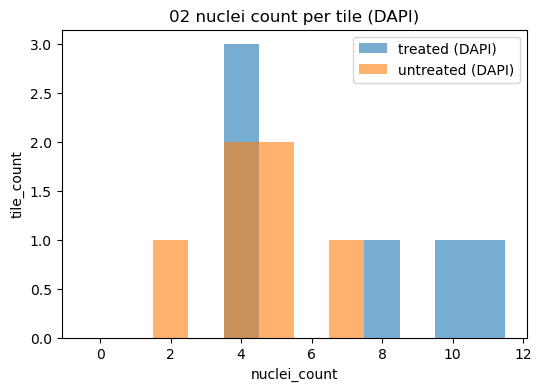

Saved: C:\Users\yixiao Zhou\Desktop\image-based-phenotyping-pipeline\figures\02_nuclei_count_per_tile__DAPI__LysosomeA_vs_LysosomeB.png


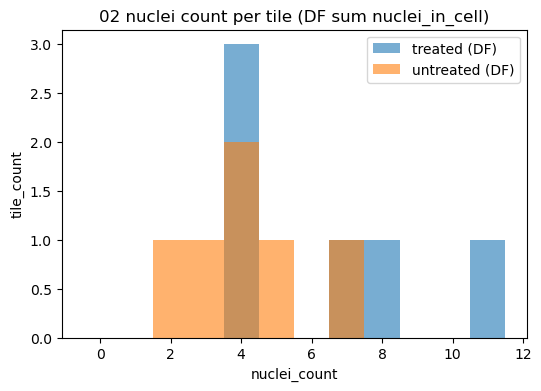

Saved: C:\Users\yixiao Zhou\Desktop\image-based-phenotyping-pipeline\figures\02_nuclei_count_per_tile__DF__LysosomeA_vs_LysosomeB.png
N nuclei (area samples): 68


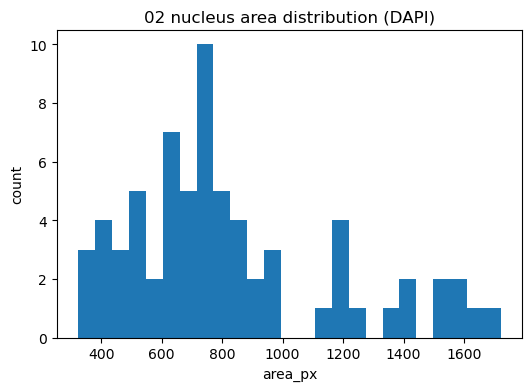

Saved: C:\Users\yixiao Zhou\Desktop\image-based-phenotyping-pipeline\figures\02_nucleus_area_hist__LysosomeA_vs_LysosomeB.png


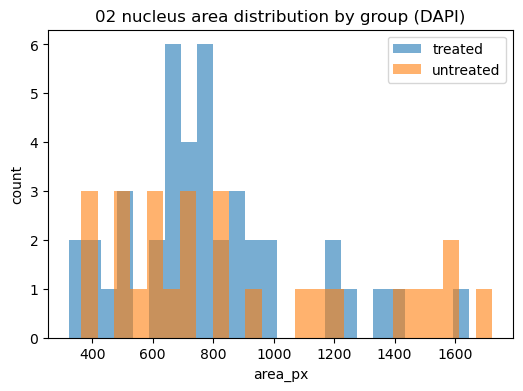

Saved: C:\Users\yixiao Zhou\Desktop\image-based-phenotyping-pipeline\figures\02_nucleus_area_hist__by_group__LysosomeA_vs_LysosomeB.png


In [2]:
# =========================================================
# QC block (drop-in for Notebook2)
# Purpose:
#   1) nuclei count per tile (DF-derived + DAPI-derived)
#   2) nucleus area histogram (DAPI-derived)
# Requirements:
#   - cfg, tiles_info, read_multichannel_tif
#   - apply_gamma, smooth, segment_nuclei (from src)
#   - df already created (cell-first table, with columns: group, tile, nuclei_in_cell, cell_class, ...)
#   - segment_nuclei_labels(cyx) exists (if not, this block provides a fallback)
# =========================================================

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from pathlib import Path
from skimage.measure import regionprops, label

# -------------------------
# 0) robust nuclei label getter
# -------------------------
def _get_nuc_labels_from_cyx(cyx):
    # preferred: use your notebook function if present
    if "segment_nuclei_labels" in globals():
        nuc_labels = segment_nuclei_labels(cyx)
        nuc_labels = nuc_labels.astype(np.int32)
        if nuc_labels.max() <= 1:
            nuc_labels = label(nuc_labels > 0).astype(np.int32)
        return nuc_labels

    # fallback: replicate nucleus segmentation here
    dapi = cyx[cfg.nucleus.dapi_channel].astype(np.float32)
    x = dapi
    if cfg.preprocess.apply_gamma:
        x = apply_gamma(x, cfg.preprocess.gamma)
    x = smooth(x, cfg.preprocess.gaussian_sigma)

    nuc = segment_nuclei(
        x,
        threshold_method=cfg.nucleus.threshold_method,
        percentile=cfg.nucleus.percentile,
        min_area=cfg.nucleus.min_area,
        max_area=cfg.nucleus.max_area,
        closing_radius=cfg.nucleus.closing_radius,
        opening_radius=cfg.nucleus.opening_radius,
        split_touching=cfg.nucleus.split_touching,
        distance_transform_sigma=cfg.nucleus.distance_transform_sigma,
        min_peak_distance=cfg.nucleus.min_peak_distance,
    ).astype(np.int32)

    if nuc.max() <= 1:
        nuc = label(nuc > 0).astype(np.int32)
    return nuc

# -------------------------
# A) nuclei count per tile
#   A1) DF-derived (depends on assignment)
#   A2) DAPI-derived (recommended)
# -------------------------
if not isinstance(df, pd.DataFrame) or len(df) == 0:
    raise RuntimeError("QC expects df to be a non-empty DataFrame (run feature extraction first).")

need_cols = {"tile", "group"}
if not need_cols.issubset(set(df.columns)):
    raise KeyError(f"QC expects df columns to include {sorted(list(need_cols))}. Got: {sorted(df.columns.tolist())}")

# A1: DF-derived nuclei count per tile (sum of nuclei_in_cell across valid cells)
if "nuclei_in_cell" in df.columns:
    df_count_per_tile = (
        df.groupby(["group", "tile"], as_index=False)["nuclei_in_cell"]
          .sum()
          .rename(columns={"nuclei_in_cell": "nuclei_count_df"})
    )
else:
    df_count_per_tile = None

# A2: DAPI-derived nuclei count per tile (independent of cell assignment)
dapi_rows = []
for item in tiles_info:
    tile_path = Path(item["tile_path"])
    group = str(item["group"])
    cyx = read_multichannel_tif(tile_path).astype(np.float32)
    nuc_labels = _get_nuc_labels_from_cyx(cyx)
    dapi_rows.append({
        "group": group,
        "tile": tile_path.name,
        "nuclei_count_dapi": int(nuc_labels.max())
    })
dapi_count_per_tile = pd.DataFrame(dapi_rows)

# Merge (optional) to compare DF vs DAPI
if df_count_per_tile is not None:
    merged_counts = pd.merge(
        dapi_count_per_tile, df_count_per_tile,
        on=["group", "tile"], how="left"
    )
else:
    merged_counts = dapi_count_per_tile.copy()

display(merged_counts.head())

# Plot: DAPI nuclei count distributions by group
plt.figure(figsize=(6, 4))
for g, sub in dapi_count_per_tile.groupby("group"):
    vals = sub["nuclei_count_dapi"].values.astype(float)
    plt.hist(vals, bins=np.arange(0, int(np.nanmax(vals)) + 2) - 0.5, alpha=0.6, label=f"{g} (DAPI)")
plt.title("02 nuclei count per tile (DAPI)")
plt.xlabel("nuclei_count")
plt.ylabel("tile_count")
plt.legend()
out_dapi = cfg.paths.figures_dir / f"02_nuclei_count_per_tile__DAPI__{A_NAME}_vs_{B_NAME}.png"
plt.savefig(out_dapi, dpi=200, bbox_inches="tight")
plt.show()
print("Saved:", out_dapi.resolve())

# Plot: DF nuclei count distributions by group (if available)
if df_count_per_tile is not None:
    plt.figure(figsize=(6, 4))
    for g, sub in df_count_per_tile.groupby("group"):
        vals = sub["nuclei_count_df"].values.astype(float)
        plt.hist(vals, bins=np.arange(0, int(np.nanmax(vals)) + 2) - 0.5, alpha=0.6, label=f"{g} (DF)")
    plt.title("02 nuclei count per tile (DF sum nuclei_in_cell)")
    plt.xlabel("nuclei_count")
    plt.ylabel("tile_count")
    plt.legend()
    out_df = cfg.paths.figures_dir / f"02_nuclei_count_per_tile__DF__{A_NAME}_vs_{B_NAME}.png"
    plt.savefig(out_df, dpi=200, bbox_inches="tight")
    plt.show()
    print("Saved:", out_df.resolve())

# -------------------------
# B) nucleus area histogram (DAPI-derived; robust)
# -------------------------
areas = []
areas_by_group = {"treated": [], "untreated": []}

for item in tiles_info:
    tile_path = Path(item["tile_path"])
    group = str(item["group"])

    cyx = read_multichannel_tif(tile_path).astype(np.float32)
    nuc_labels = _get_nuc_labels_from_cyx(cyx)

    props = regionprops(nuc_labels)
    a = [float(p.area) for p in props]
    areas.extend(a)
    if group in areas_by_group:
        areas_by_group[group].extend(a)

areas = np.asarray(areas, dtype=np.float32)
print("N nuclei (area samples):", int(areas.size))

plt.figure(figsize=(6, 4))
if areas.size > 0:
    plt.hist(areas, bins=25)
plt.title("02 nucleus area distribution (DAPI)")
plt.xlabel("area_px")
plt.ylabel("count")
out_area = cfg.paths.figures_dir / f"02_nucleus_area_hist__{A_NAME}_vs_{B_NAME}.png"
plt.savefig(out_area, dpi=200, bbox_inches="tight")
plt.show()
print("Saved:", out_area.resolve())

# Optional: by-group area overlay (often reveals thresholding bias)
plt.figure(figsize=(6, 4))
for g, arr in areas_by_group.items():
    arr = np.asarray(arr, dtype=np.float32)
    if arr.size == 0:
        continue
    plt.hist(arr, bins=25, alpha=0.6, label=g)
plt.title("02 nucleus area distribution by group (DAPI)")
plt.xlabel("area_px")
plt.ylabel("count")
plt.legend()
out_area_g = cfg.paths.figures_dir / f"02_nucleus_area_hist__by_group__{A_NAME}_vs_{B_NAME}.png"
plt.savefig(out_area_g, dpi=200, bbox_inches="tight")
plt.show()
print("Saved:", out_area_g.resolve())


Saved: C:\Users\yixiao Zhou\Desktop\image-based-phenotyping-pipeline\figures\02_qc_panel__tile_019_y576_x768_C4__LysosomeA_vs_LysosomeB.png


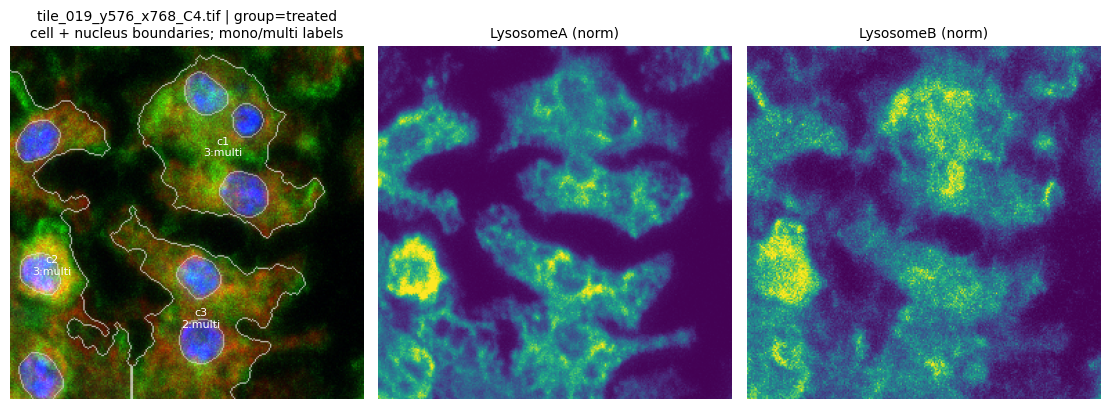

Saved: C:\Users\yixiao Zhou\Desktop\image-based-phenotyping-pipeline\figures\02_qc_panel__tile_020_y768_x0_C4__LysosomeA_vs_LysosomeB.png


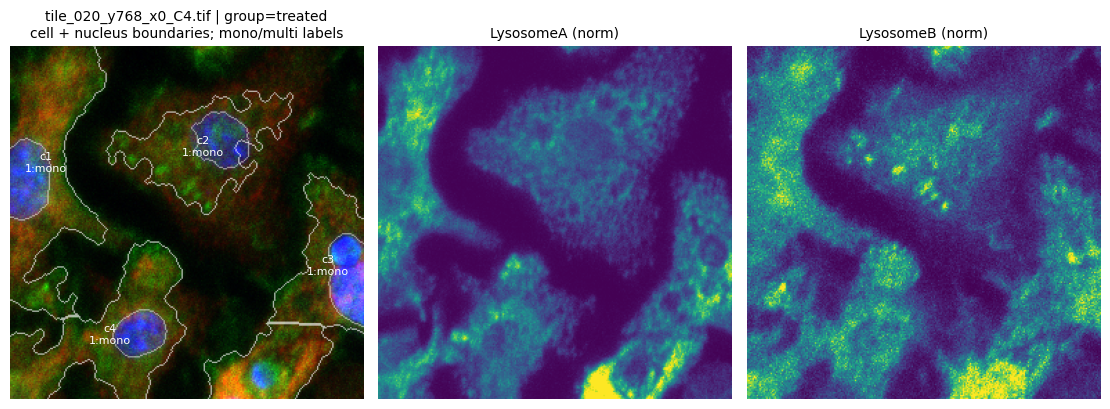

Saved: C:\Users\yixiao Zhou\Desktop\image-based-phenotyping-pipeline\figures\02_qc_panel__tile_021_y768_x192_C4__LysosomeA_vs_LysosomeB.png


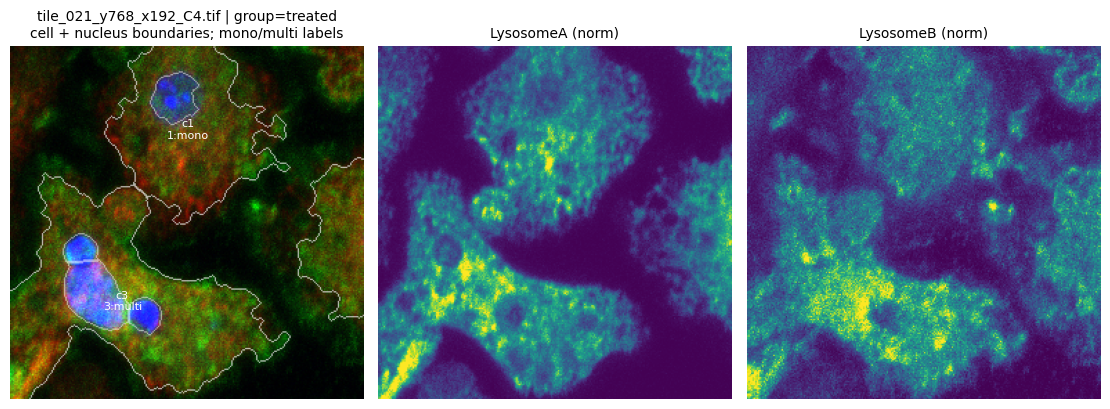

Saved: C:\Users\yixiao Zhou\Desktop\image-based-phenotyping-pipeline\figures\02_qc_panel__tile_022_y768_x384_C4__LysosomeA_vs_LysosomeB.png


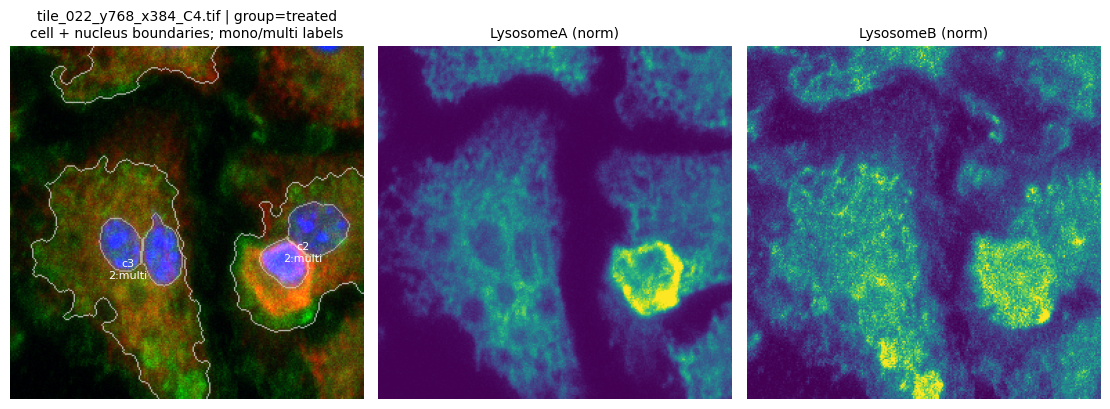

Saved: C:\Users\yixiao Zhou\Desktop\image-based-phenotyping-pipeline\figures\02_qc_panel__tile_023_y768_x576_C4__LysosomeA_vs_LysosomeB.png


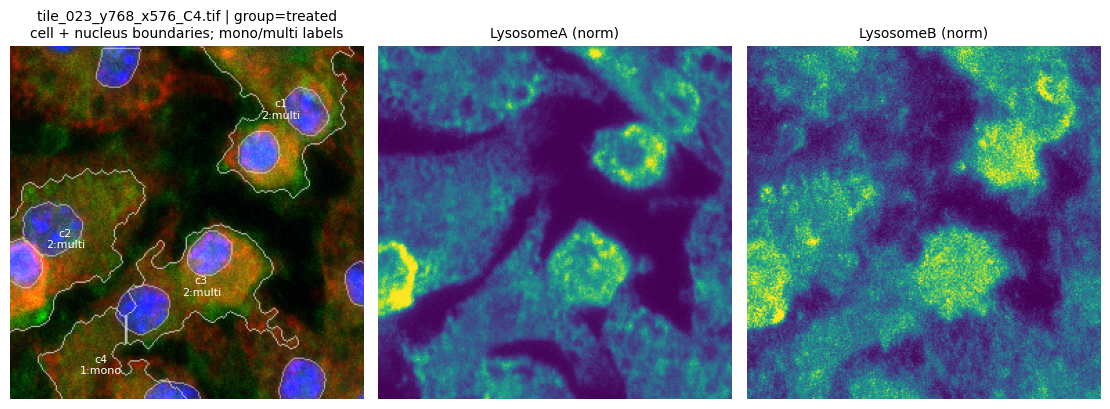

Saved: C:\Users\yixiao Zhou\Desktop\image-based-phenotyping-pipeline\figures\02_qc_panel__tile_024_y768_x768_C4__LysosomeA_vs_LysosomeB.png


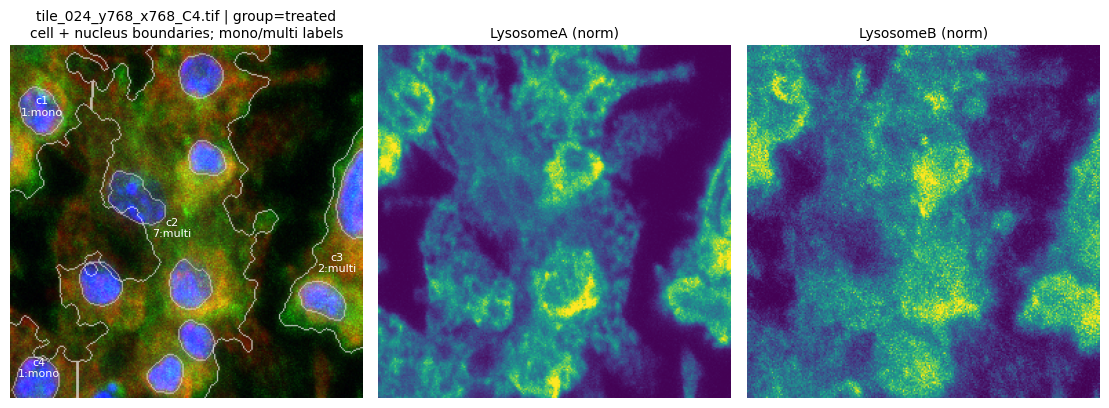

In [5]:
import numpy as np
import matplotlib.pyplot as plt
from pathlib import Path
from skimage.segmentation import find_boundaries

def _norm01_view(x, eps=1e-8, p_lo=1.0, p_hi=99.5):
    x = x.astype(np.float32)
    lo = np.percentile(x, p_lo)
    hi = np.percentile(x, p_hi)
    y = (x - lo) / (hi - lo + eps)
    return np.clip(y, 0, 1)

def _tile_group_lookup(tile_name):
    if "tiles_info" not in globals():
        return None
    for it in tiles_info:
        if Path(it["tile_path"]).name == tile_name:
            return str(it.get("group", ""))
    return None

def render_qc_panel_for_tile(tile_path, out_path=None, max_cells_to_label=30):
    tile_path = Path(tile_path)
    cyx = read_multichannel_tif(tile_path).astype(np.float32)  # (C, Y, X)

    A = cyx[ANALYSIS_CHANNEL_A].astype(np.float32)
    B = cyx[ANALYSIS_CHANNEL_B].astype(np.float32)

    # segmentation (must match Notebook2 signatures)
    cell_mask, cell_labels = segment_cells_from_AB(A, B)
    nuc_labels = segment_nuclei_labels(cyx)  # single return in your Notebook2
    nuc2cell, n_per_cell = assign_nuclei_to_cells(nuc_labels, cell_labels, min_overlap_px=NUC_CELL_MIN_OVERLAP_PX)

    # boundaries
    b_cell = find_boundaries(cell_labels, mode="outer")
    b_nuc  = find_boundaries(nuc_labels,  mode="outer")

    # RGB overlay (force float in [0,1] for safe editing)
    rgb = make_rgb(cyx, cfg.preview.rgb_channels).astype(np.float32)

    # robust scaling: handle either [0,1] float OR [0,255] uint8
    mx = float(rgb.max())
    if mx > 1.5:          # typical when rgb is uint8-like
        rgb = rgb / 255.0
    rgb = np.clip(rgb, 0, 1)

    rgb[b_cell] = np.clip(0.35 * rgb[b_cell] + 0.65, 0, 1)   # cell 边界提亮但不全白
    rgb[b_nuc]  = np.clip(0.50 * rgb[b_nuc]  + 0.50, 0, 1)   # nucleus 边界更柔和


    # normalized channel views
    A_norm = _norm01_view(A)
    B_norm = _norm01_view(B)

    group = _tile_group_lookup(tile_path.name)
    group_txt = f" | group={group}" if group else ""

    fig = plt.figure(figsize=(11.2, 4.2))
    ax1 = plt.subplot(1, 3, 1)
    ax2 = plt.subplot(1, 3, 2)
    ax3 = plt.subplot(1, 3, 3)

    ax1.imshow(rgb)
    ax1.set_title(f"{tile_path.name}{group_txt}\ncell + nucleus boundaries; mono/multi labels", fontsize=10)
    ax1.axis("off")

    # label cells by nuclei count; label big cells first
    cell_ids = np.unique(cell_labels)
    cell_ids = cell_ids[cell_ids > 0]

    areas = [(int(cid), int(np.sum(cell_labels == cid))) for cid in cell_ids]
    areas.sort(key=lambda x: x[1], reverse=True)

    n_labeled = 0
    for cid, _a in areas:
        k = int(n_per_cell.get(int(cid), 0))
        if k <= 0:
            continue
        rr, cc = np.where(cell_labels == cid)
        if rr.size == 0:
            continue
        cls = "mono" if k == 1 else "multi"
        ax1.text(float(cc.mean()), float(rr.mean()), f"c{cid}\n{k}:{cls}",
                 color="white", fontsize=8, ha="center", va="center")
        n_labeled += 1
        if n_labeled >= int(max_cells_to_label):
            break

    ax2.imshow(A_norm)
    ax2.set_title(f"{A_NAME} (norm)", fontsize=10)
    ax2.axis("off")

    ax3.imshow(B_norm)
    ax3.set_title(f"{B_NAME} (norm)", fontsize=10)
    ax3.axis("off")

    plt.tight_layout()

    if out_path is not None:
        out_path = Path(out_path)
        out_path.parent.mkdir(parents=True, exist_ok=True)
        plt.savefig(out_path, dpi=200, bbox_inches="tight")
        print("Saved:", out_path.resolve())

    plt.show()

# -------------------------
# Run QC panels for a few tiles
# -------------------------
QC_N_TILES = 6
QC_TILE_START = 0

for i in range(QC_TILE_START, min(QC_TILE_START + QC_N_TILES, len(tiles))):
    p = Path(tiles[i])
    out = (cfg.paths.figures_dir / f"02_qc_panel__{p.stem}__{A_NAME}_vs_{B_NAME}.png") if SAVE_FIGURES else None
    render_qc_panel_for_tile(p, out_path=out, max_cells_to_label=25)
